In [1]:
import ipynb
import geopandas as gpd
import shapely.geometry as geom
from shapely.geometry import mapping
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import os
import joblib
from shapely.geometry import shape, Polygon
from pathlib import Path



In [2]:
# import feature cube generator
from ipynb.fs.defs.featurecube import build_feature_cube

# import baseline model trainer
from ipynb.fs.defs.baseline_model_train_pl import train_baseline_model

# import temporial anomaly pipeline
from ipynb.fs.defs.temporial_anomaly_pipleine import temporal_anomaly_scoring_safe

# import temporial state inference pipeline
from ipynb.fs.defs.temporial_state_pipeline import run_excavation_pipeline

# import spacial object formation pipeline
from ipynb.fs.defs.space_object_form_pipeline import spatial_objects_formation , spatial_objects_degrees

# Baseline mask 
from ipynb.fs.defs.baseline_excavation_mask_pipeline import build_baseline_mining_mask

# No zone polygons
from ipynb.fs.defs.zone_polygons import get_zones

# Mine level aggregation
from ipynb.fs.defs.mine_level_temp_aggr_pipeline import mine_level_temporal_aggregation

# Alert logging system
from ipynb.fs.defs.no_go_zone_alert_pipeline import generate_no_go_zone_alerts

# Save AOIs
from ipynb.fs.defs.save_aoi_pipeline import save_all_aois


In [3]:
TARGET_CRS = "EPSG:32466"

In [4]:
CRS = "32644"

In [ ]:
## Get AOI's

# Get mine polygon
mine_id = 0
MINE_ID = f"MINE_{mine_id}"

mine = gpd.read_file("content/mines/mines_cils.shp")
mine_sel = mine.iloc[[mine_id]]   # select one mine


# Maintain same CRS
if mine_sel.crs is None or mine_sel.crs.to_epsg() != CRS:
    mine_sel = mine_sel.to_crs(epsg=CRS)

# get geometry
geom_sel = mine_sel.geometry.iloc[0]



baseline_aoi, monitor_aoi, no_go_zone_aoi = get_zones(geom_sel, shrink_distance=50)


In [6]:
type(geom_sel)

shapely.geometry.polygon.Polygon

In [9]:
save_all_aois(
    mine_id=mine_id,
    baseline_aoi=baseline_aoi,
    monitor_aoi=monitor_aoi,
    no_go_zone_aoi=no_go_zone_aoi,
    crs=mine_sel.crs,
    base_dir="data/mines"
)


In [ ]:
# Data DIRs

BASE_DATA_DIR = f"content/{MINE_ID}/baseline"
MON_DATA_DIR = f"content/{MINE_ID}/monitor"
MODEL_DIR = "baseline_models" 

In [11]:
x_pt_base = build_feature_cube(BASE_DATA_DIR, mapping(baseline_aoi))
x_pt_mon = build_feature_cube(MON_DATA_DIR, mapping(monitor_aoi))

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [12]:
# Get baseline model

MINE_ID = f"MINE_{mine_id}"

model_path = os.path.join(MODEL_DIR, f"{MINE_ID}_baseline_model.joblib")

if os.path.exists(model_path):
    baseline_model = joblib.load(model_path)

else:
    baseline_model = train_baseline_model(
        x_pt=x_pt_base,
        mine_id= MINE_ID
    )


In [13]:
# Temporial anamoly detection

monitor_df, anomaly_maps, stats  = temporal_anomaly_scoring_safe(
    monitoringcube = x_pt_mon,
    BaselineModel = baseline_model
)


In [14]:
monitor_df.to_csv(
  f"data/mines/{MINE_ID}/pixel_anomaly_timeseries.csv",
  index=False
)


In [15]:
# Temporial state detection

monitor_df, state_maps, excavation_maps = run_excavation_pipeline(
    monitor_df,
    window=3,
    anomaly_quantile=0.85,
    
    #persistence_days=15
)



/home/manikanta/Desktop/aurora/temporial_state_pipeline.ipynb:178: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "\n",


In [16]:
monitor_df.to_csv(
  f"data/mines/{MINE_ID}/pixel_state_timeseries.csv",
  index=False
)


In [17]:
# Baseline excavatd mask

baseline_mining_mask , _ = build_baseline_mining_mask(x_pt_base)

In [18]:
print(
    "Baseline mask positives:",
    int((baseline_mining_mask == 1).sum())
)


Baseline mask positives: 331


In [19]:
baseline_mining_mask.rio.write_nodata(0, inplace=True)
baseline_mining_mask.rio.to_raster(
    f"data/mines/{MINE_ID}/baseline_mining_mask.tif"
)


In [20]:
REFERENCE_CRS = x_pt_mon.rio.crs  # NO PARENTHESES - it's a property!   
REFERENCE_CRS

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]')

In [21]:
# Fix CRS for all excavationmaps and statemaps
REFERENCE_CRS = x_pt_mon.rio.crs  # NO PARENTHESES - it's a property!   

if REFERENCE_CRS :
    REFERENCE_CRS = f"EPSG:{CRS}"  # Visakhapatnam UTM zone
    print(f"Using fallback CRS: EPSG:{CRS}")

print(f"Reference CRS: {REFERENCE_CRS}")

# Apply to all maps
for t in excavation_maps:
    excavation_maps[t] = excavation_maps[t].rio.write_crs(REFERENCE_CRS)

for t in state_maps:
    state_maps[t] = state_maps[t].rio.write_crs(REFERENCE_CRS)

print("CRS set on all maps!")


Using fallback CRS: EPSG:32644
Reference CRS: EPSG:32644
CRS set on all maps!


In [22]:
# Spacial object fromation 

objectsgdf = spatial_objects_degrees(excavation_maps, mine_sel, min_pixels=0)



2022-07-17 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-08-01 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-08-11 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-08-31 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-09-10 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-09-30 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)
2022-10-15 00:00:00: 2 pixels
  → 0 objects (≥0 pixels)


In [23]:
objectsgdf.crs

<Projected CRS: EPSG:32644>
Name: WGS 84 / UTM zone 44N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°E and 84°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Nepal. Russian Federation. Sri Lanka.
- bounds: (78.0, 0.0, 84.0, 84.0)
Coordinate Operation:
- name: UTM zone 44N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
objectsgdf.to_file(
  f"data/mines/{MINE_ID}/objects.geojson",
  driver="GeoJSON"
)


In [25]:
print(objectsgdf.columns)


Index(['date', 'start_date', 'pixel_count', 'area_ha', 'confidence', 'area',
       'perimeter', 'geometry'],
      dtype='object')


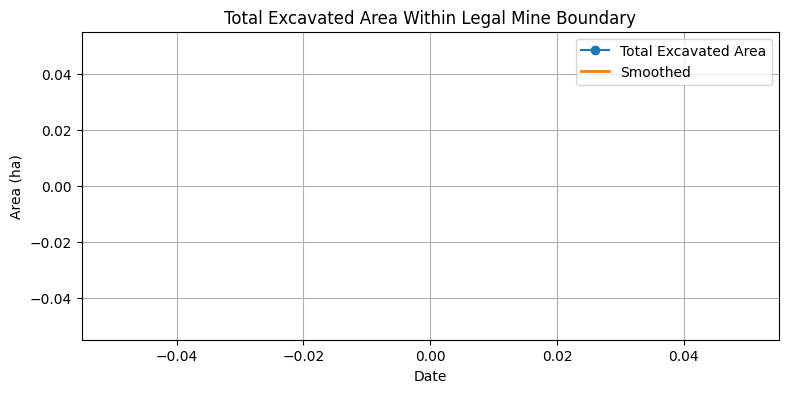

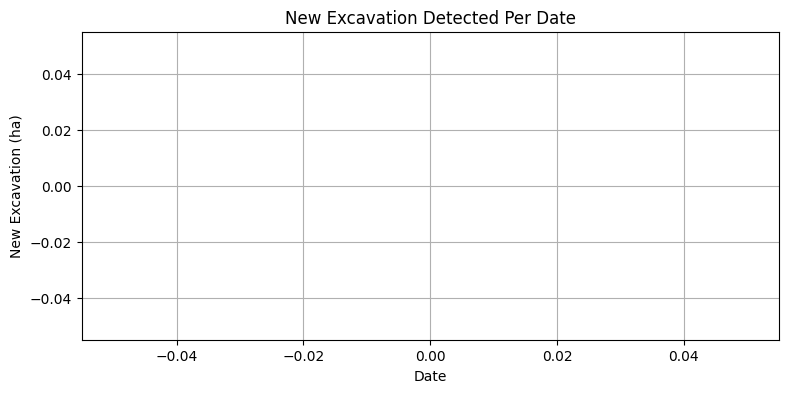

,date,total_excavated_area_ha,new_excavation_ha,recovered_ha,net_change_ha,excavation_rate_ha_per_step,total_excavated_area_smooth


In [26]:
# Mine level aggregation
mine_ts = mine_level_temporal_aggregation(
    objectsgdf,
    smooth_window=3,
    export_csv_path="results/mine_level_excavation_timeseries.csv",
    make_plots=True
)

mine_ts.head()


In [27]:
mine_ts.to_csv(
  f"data/mines/{MINE_ID}/mine_timeseries.csv",
  index=False
)


In [28]:
## Alert logging system

# Get no go zone gdf
nogozones_gdf = gpd.GeoDataFrame(
    {
        "zone_id": ["NGZ_001"],
        "geometry": [no_go_zone_aoi]
    },
    crs=f"EPSG:{CRS}"
)


alerts_df, violation_df = generate_no_go_zone_alerts(


    objects_gdf=objectsgdf,
    nogozones_gdf = nogozones_gdf,
    mine_id=MINE_ID,
    area_eps=0.005,
    stable_steps=3
)

alerts_df.head()


""


In [29]:
alerts_df.to_csv(
  f"data/mines/{MINE_ID}/no_go_alerts.csv",
  index=False
)


Plots

In [30]:
print("Dates:", len(objectsgdf["date"].unique()))
print("Objects:", len(objectsgdf))
print("Min pixels:", objectsgdf["pixel_count"].min())


Dates: 0
Objects: 0
Min pixels: nan


/tmp/ipykernel_101576/1481619599.py:18: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  objectsgdf.plot(ax=ax,


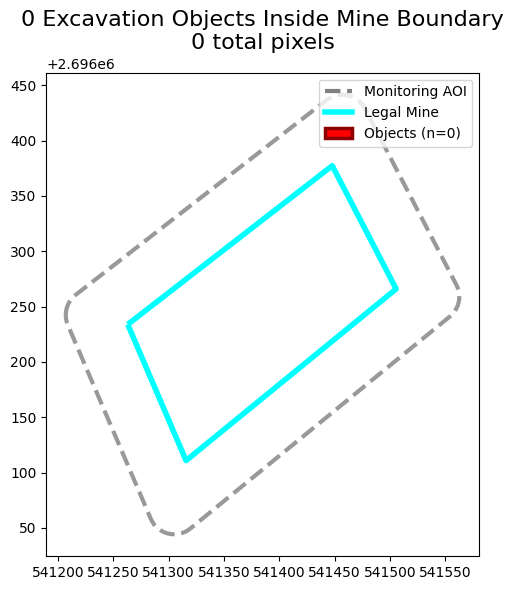

In [31]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(6, 6))


baseline_gdf = gpd.GeoDataFrame(
    geometry=[baseline_aoi], 
    crs=f"EPSG:{CRS}"  # matches mine_sel
)

# 2. Legal mine boundary (cyan solid)
baseline_gdf.boundary.plot(ax=ax, color='cyan', linewidth=4, label='Legal Mine')

# 3. SPATIAL OBJECTS - FIXED visibility
# Use linewidth + facecolor scaling instead of markersize
objectsgdf.plot(ax=ax, 
                color='red',           # solid red fill
                edgecolor='darkred',   # thick black edges
                linewidth=2.5,         # THICK lines = visible
                alpha=0.85,            # slight transparency
                label=f'Excavation Objects (n={len(objectsgdf)})')

# 1. Monitoring AOI (gray dashed)
AOI_gdf = gpd.GeoDataFrame(geometry=[shape(monitor_aoi)], crs=f"EPSG:{CRS}")
AOI_gdf.boundary.plot(ax=ax, color='gray', linewidth=3, linestyle='--', alpha=0.8, label='Monitoring AOI')

# Manual legend (avoids PatchCollection warning)
handles = [
    plt.Line2D([0], [0], color='gray', lw=3, ls='--', label='Monitoring AOI'),
    plt.Line2D([0], [0], color='cyan', lw=4, label='Legal Mine'),
    Patch(facecolor='red', edgecolor='darkred', lw=2.5, label=f'Objects (n={len(objectsgdf)})')
]
ax.legend(handles=handles)

ax.set_title(f'{len(objectsgdf)} Excavation Objects Inside Mine Boundary\n'
             f'{objectsgdf["pixel_count"].sum():,} total pixels', fontsize=16)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


/tmp/ipykernel_101576/2571540552.py:9: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  objectsgdf.plot(ax=ax,


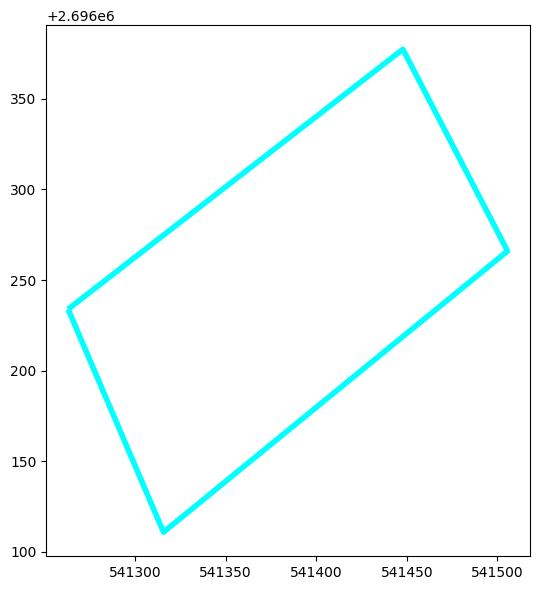

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
# 3. SPATIAL OBJECTS - FIXED visibility


# 2. Legal mine boundary (cyan solid)
baseline_gdf.boundary.plot(ax=ax, color='cyan', linewidth=4, label='Legal Mine')

# Use linewidth + facecolor scaling instead of markersize
objectsgdf.plot(ax=ax, 
                color='red',           # solid red fill
                edgecolor='darkred',   # thick black edges
                linewidth=2.5,         # THICK lines = visible
                alpha=0.85,            # slight transparency
                label=f'Excavation Objects (n={len(objectsgdf)})')

plt.tight_layout()
plt.show()